In [14]:
# Import required Python packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import joblib
import shap
import matplotlib.pyplot as plt
# Specify the type of features to use: either all metrics or derived indicators
DEMorAll = "AllMetrics"  # Options: DemDerivedIndicators OR AllMetrics

# Load the dataset
data01 = pd.read_csv('Dataset\1844Points.csv', encoding='gbk')

# Rename columns for better understanding
data01.columns = ['FID', 'X', 'Y', 'Aspect', 'Elevation', 'Distance to lineament', 'Lineament density', 
                  'NDVI', 'Plan curvature', 'Profile curvature', 'Slope', 'Slope length', 'STI',
                  'SPI', 'TPI', 'TWI', 'VRM', 'LULC', 'Habitat', 'GDP',
                  'Distance from River', 'Distance from Road', 'target']

# Drop unnecessary columns based on the selected feature type
columns_to_drop = ['FID', 'X', 'Y'] if DEMorAll == 'AllMetrics' else ['FID', 'X', 'Y', 
                                                                     'LULC', 'Habitat', 'GDP', 'NDVI', 'Distance from Road']
data01.drop(columns=columns_to_drop, inplace=True)  # Remove specified columns from the dataset

# Define model path for saving or loading
model_path = 'Output\light_{}.model'.format(DEMorAll)
seed = 4  # Set random seed for reproducibility

# Save the column names
header = data01.columns.tolist()

# Split the dataset into two dataframes based on the target value
data_0 = data01.loc[data01['target'] == 0]  # Rows with target = 0
data_1 = data01.loc[data01['target'] == 1]  # Rows with target = 1

# Split target = 0 data into 80% training and 20% validation sets
data_0_X = data_0.drop(columns=["target"], axis=1)
data_0_Y = data_0.target
train_0_X, valid_0_X, train_0_y, valid_0_y = train_test_split(data_0_X, data_0_Y, test_size=0.2, random_state=seed)
save_TrainDate_0 = pd.DataFrame(np.column_stack([train_0_X, train_0_y]), columns=header)
save_ValidDate_0 = pd.DataFrame(np.column_stack([valid_0_X, valid_0_y]), columns=header)

# Split target = 1 data into 80% training and 20% validation sets
data_1_X = data_1.drop(columns=["target"], axis=1)
data_1_Y = data_1.target
train_1_X, valid_1_X, train_1_y, valid_1_y = train_test_split(data_1_X, data_1_Y, test_size=0.2, random_state=seed)
save_TrainDate_1 = pd.DataFrame(np.column_stack([train_1_X, train_1_y]), columns=header)
save_ValidDate_1 = pd.DataFrame(np.column_stack([valid_1_X, valid_1_y]), columns=header)

# Combine training datasets and shuffle the data to avoid ordering bias
train_date = pd.concat([save_TrainDate_0, save_TrainDate_1])
train_date = train_date.sample(frac=1, random_state=42)

# Combine validation datasets and shuffle the data to avoid ordering bias
valid_date = pd.concat([save_ValidDate_0, save_ValidDate_1])
valid_date = valid_date.sample(frac=1, random_state=42)

# Separate features (X) and target (y) from the training dataset
train_y = train_date.target
train_X = train_date.drop(columns=[ "target"], axis=1)

# Separate features (X) and target (y) from the validation dataset
valid_y = valid_date.target
valid_X = valid_date.drop(columns=["target"], axis=1)


******* Best Score *******
0.850781592403214


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Best AUC Score: 0.850781592403214


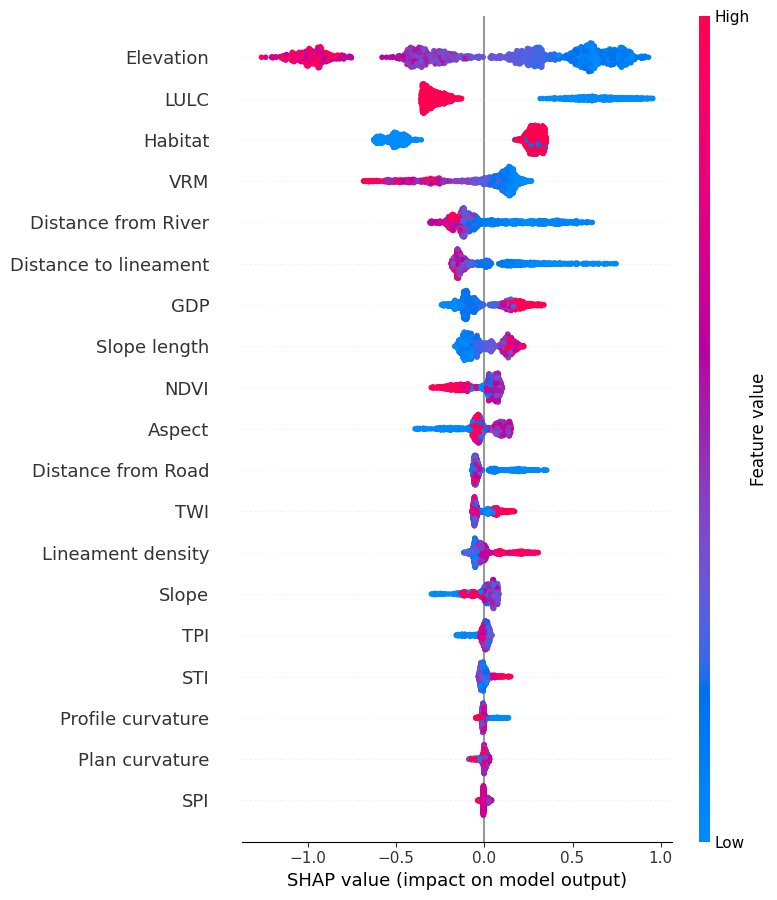

In [15]:

# Load the pre-trained LightGBM model
light_model = joblib.load(model_path)

# Retrieve the best AUC score from the model
best_score = light_model.best_score_['valid_1']['auc']
print("******* Best Score *******")
print(best_score)

# Use SHAP (SHapley Additive exPlanations) to interpret the model's predictions
explainer = shap.TreeExplainer(light_model)  # Create SHAP explainer for the model
shap_values = explainer.shap_values(train_X)  # Calculate SHAP values for the training set

# Generate a SHAP summary plot to show feature importance
shap.summary_plot(shap_values[1],  # SHAP values for the positive class
                  train_X, 
                  plot_type="dot",  # Dot plot type for better visualization
                  show=False,  # Do not immediately display the plot
                  sort=True,  # Sort features by importance
                  max_display=21)  # Display the top 21 features

# Print the best AUC score for reference
print("Best AUC Score:", best_score)


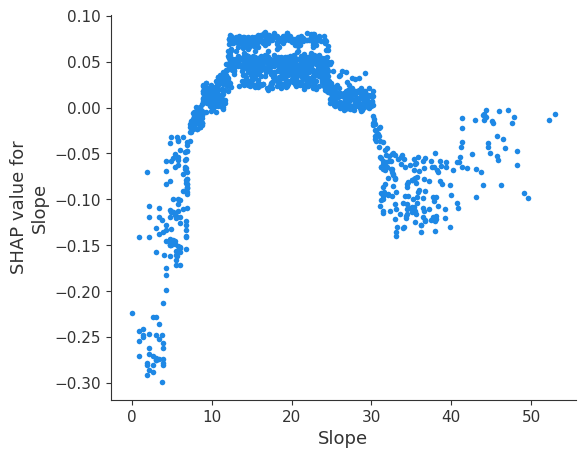

In [16]:
shap.dependence_plot('Slope',
                     shap_values[1],
                     train_X,
                     interaction_index=None)

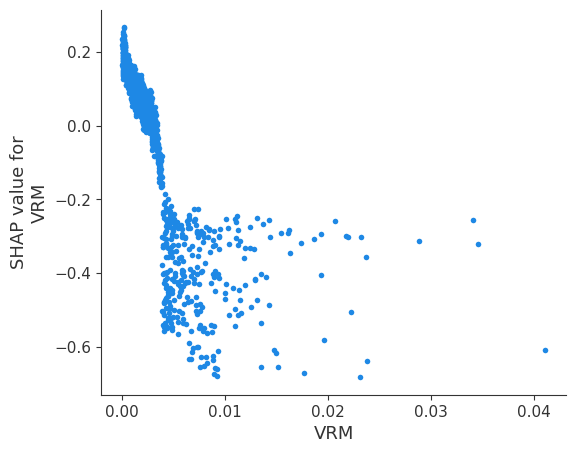

In [17]:
shap.dependence_plot('VRM', shap_values[1], train_X, interaction_index=None)

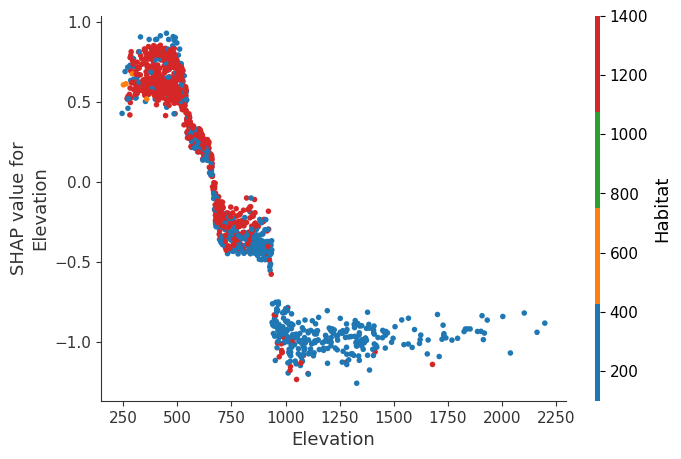

In [18]:
from matplotlib.colors import ListedColormap

# 定义颜色
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#d62728','#d62728','#d62728']  # 可以选择你喜欢的颜色
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  

# 创建定性色带
qualitative_cmap = ListedColormap(colors)
cmap = plt.get_cmap('hsv')

# 绘制依赖图
shap.dependence_plot(ind='Elevation', 
                     interaction_index='Habitat', 
                     shap_values=shap_values[1],  # 确保这里是正确的 SHAP 值
                     features=train_X, 
                     display_features=train_X,
                     cmap=qualitative_cmap  # 添加自定义的颜色映射
#                      cmap = cmap
                    )

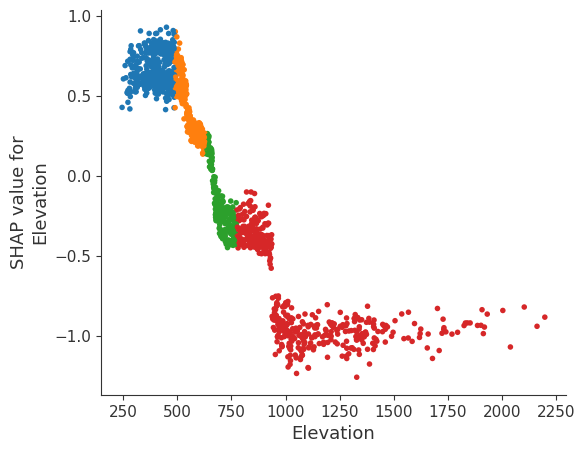

In [20]:
from matplotlib.colors import ListedColormap

# 定义颜色
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#d62728','#d62728','#d62728']  # 可以选择你喜欢的颜色
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  

# 创建定性色带
qualitative_cmap = ListedColormap(colors)
cmap = plt.get_cmap('hsv')

# 绘制依赖图
shap.dependence_plot(ind='Elevation', 
                     interaction_index='Elevation', 
                     shap_values=shap_values[1],  # 确保这里是正确的 SHAP 值
                     features=train_X, 
                     display_features=train_X,
                     cmap=qualitative_cmap  # 添加自定义的颜色映射
#                      cmap = cmap
                    )